# Deep Learning: LSTM & GRU

**Ziel:** Recurrent Neural Networks für Zeitreihenvorhersage

**Modelle:**
1. Simple RNN (Baseline)
2. LSTM (Long Short-Term Memory)
3. GRU (Gated Recurrent Unit)
4. Bidirectional LSTM
5. Stacked LSTM

**Basierend auf:** Week05_RNNs_LSTM_GRU

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from evaluation.metrics import calculate_metrics, print_metrics, compare_models
from visualization.plots import plot_forecast, plot_multiple_forecasts

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cpu


## 1. Daten laden und vorbereiten

In [2]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

# 1. Lade skalierte Daten für das Training
train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train_scaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val_scaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test_scaled.csv', parse_dates=['timestamp'])

# 2. Lade Original-Daten um den Scaler zu rekonstruieren (WICHTIG für Vergleich!)
train_df_original = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])

# Scaler neu fitten
scaler = StandardScaler()
scaler.fit(train_df_original[['value']])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Scaler Mean: {scaler.mean_[0]:.2f}, Scale: {scaler.scale_[0]:.2f}")

Train: 18262 | Val: 3913 | Test: 3914
Scaler Mean: 6184.30, Scale: 9627.69


## 2. Sequenzen erstellen

RNNs benötigen Sequenzen als Input: (sequence_length, features)

In [3]:
def create_sequences(data, seq_length, target_col='value'):
    """
    Create sequences for RNN training
    
    Args:
        data: DataFrame with features
        seq_length: Length of input sequence
        target_col: Name of target column
    
    Returns:
        X, y arrays
    """
    X, y = [], []
    
    # Nur value für einfache Modelle
    values = data[target_col].values
    
    for i in range(len(values) - seq_length):
        X.append(values[i:i+seq_length])
        y.append(values[i+seq_length])
    
    return np.array(X), np.array(y)

# Sequenzlänge (z.B. 24 Stunden für stündliche Daten)
SEQ_LENGTH = 24

X_train, y_train = create_sequences(train_df, SEQ_LENGTH)
X_val, y_val = create_sequences(val_df, SEQ_LENGTH)
X_test, y_test = create_sequences(test_df, SEQ_LENGTH)

# Reshape für PyTorch: (samples, seq_length, features)
X_train = X_train.reshape(-1, SEQ_LENGTH, 1)
X_val = X_val.reshape(-1, SEQ_LENGTH, 1)
X_test = X_test.reshape(-1, SEQ_LENGTH, 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (18238, 24, 1)
y_train shape: (18238,)


## 3. PyTorch Dataset und DataLoader

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create dataloaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoaders created")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

✅ DataLoaders created
Train batches: 285
Val batches: 61


## 4. Model Definitions

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x shape: (batch, seq, features)
        lstm_out, _ = self.lstm(x)
        # Take last output
        last_output = lstm_out[:, -1, :]
        predictions = self.fc(last_output)
        return predictions.squeeze()


class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]
        predictions = self.fc(last_output)
        return predictions.squeeze()


class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=True
        )
        
        # *2 because bidirectional
        self.fc = nn.Linear(hidden_size * 2, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        predictions = self.fc(last_output)
        return predictions.squeeze()

print("✅ Models defined")

✅ Models defined


## 5. Training Function

In [6]:
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001):
    """
    Train a PyTorch model
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")
        
        if patience_counter >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return model, train_losses, val_losses


def predict(model, data_loader):
    """
    Make predictions with a trained model
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            pred = model(X_batch)
            predictions.extend(pred.cpu().numpy())
    
    return np.array(predictions)

print("✅ Training functions defined")

✅ Training functions defined


## 6. Train LSTM

In [7]:
print("Training LSTM...\n")

lstm_model = LSTMModel(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

lstm_model, lstm_train_loss, lstm_val_loss = train_model(
    lstm_model,
    train_loader,
    val_loader,
    epochs=50,
    lr=0.001
)

# Predict
lstm_pred_scaled = predict(lstm_model, test_loader)

# Inverse Transform (Zurückrechnen auf MW)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate on ORIGINAL scale
lstm_metrics = calculate_metrics(y_test_original, lstm_pred, prefix='test_')
print("\n")
print_metrics(lstm_metrics, "LSTM (Original Scale)")

Training LSTM...

Epoch 10/50 - Train Loss: 0.004185 - Val Loss: 0.003728
Epoch 20/50 - Train Loss: 0.003303 - Val Loss: 0.003914
Epoch 30/50 - Train Loss: 0.002318 - Val Loss: 0.002499
Epoch 40/50 - Train Loss: 0.001953 - Val Loss: 0.002309
Epoch 50/50 - Train Loss: 0.001873 - Val Loss: 0.002317


                   LSTM (Original Scale)                    
  test_mae       :     208.21
  test_rmse      :     415.29
  test_mape      :      82.69%
  test_smape     :      68.87%
  test_r2        :     0.9984
  test_mase      :       0.12


## 7. Train GRU

In [8]:
print("Training GRU...\n")

gru_model = GRUModel(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

gru_model, gru_train_loss, gru_val_loss = train_model(
    gru_model,
    train_loader,
    val_loader,
    epochs=50,
    lr=0.001
)

gru_pred_scaled = predict(gru_model, test_loader)

# Inverse Transform
gru_pred = scaler.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate
gru_metrics = calculate_metrics(y_test_original, gru_pred, prefix='test_')
print("\n")
print_metrics(gru_metrics, "GRU (Original Scale)")

Training GRU...

Epoch 10/50 - Train Loss: 0.003448 - Val Loss: 0.003067
Epoch 20/50 - Train Loss: 0.002543 - Val Loss: 0.003040
Epoch 30/50 - Train Loss: 0.002233 - Val Loss: 0.002440
Epoch 40/50 - Train Loss: 0.002044 - Val Loss: 0.002413
Epoch 50/50 - Train Loss: 0.001828 - Val Loss: 0.002240


                    GRU (Original Scale)                    
  test_mae       :     216.46
  test_rmse      :     395.99
  test_mape      :     230.75%
  test_smape     :      93.72%
  test_r2        :     0.9986
  test_mase      :       0.12


## 8. Train Bidirectional LSTM

In [9]:
print("Training Bidirectional LSTM...\n")

bilstm_model = BiLSTMModel(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)

bilstm_model, bilstm_train_loss, bilstm_val_loss = train_model(
    bilstm_model,
    train_loader,
    val_loader,
    epochs=50,
    lr=0.001
)

bilstm_pred_scaled = predict(bilstm_model, test_loader)

# Inverse Transform
bilstm_pred = scaler.inverse_transform(bilstm_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate
bilstm_metrics = calculate_metrics(y_test_original, bilstm_pred, prefix='test_')
print("\n")
print_metrics(bilstm_metrics, "Bidirectional LSTM (Original Scale)")

Training Bidirectional LSTM...

Epoch 10/50 - Train Loss: 0.003251 - Val Loss: 0.002491
Epoch 20/50 - Train Loss: 0.002404 - Val Loss: 0.003386
Epoch 30/50 - Train Loss: 0.001901 - Val Loss: 0.002405
Epoch 40/50 - Train Loss: 0.001605 - Val Loss: 0.002116
Epoch 50/50 - Train Loss: 0.001591 - Val Loss: 0.002022


            Bidirectional LSTM (Original Scale)             
  test_mae       :     198.37
  test_rmse      :     365.46
  test_mape      :     268.88%
  test_smape     :      98.48%
  test_r2        :     0.9988
  test_mase      :       0.11


## 9. Model Comparison

In [10]:
all_results = {
    'LSTM': lstm_metrics,
    'GRU': gru_metrics,
    'BiLSTM': bilstm_metrics
}

comparison_df = compare_models(all_results, sort_by='test_rmse')

print("\n" + "=" * 80)
print("DEEP LEARNING MODELS - COMPARISON (ORIGINAL SCALE)")
print("=" * 80)
display(comparison_df.round(2))

best_model_name = comparison_df['test_rmse'].idxmin()
print(f"\n🏆 Best Model: {best_model_name}")

# Save results
comparison_df.to_csv('../results/metrics/solar_deep_learning_results.csv')


DEEP LEARNING MODELS - COMPARISON (ORIGINAL SCALE)


,test_mae,test_rmse,test_mape,test_smape,test_r2,test_mase
BiLSTM,198.37,365.46,268.88,98.48,1.0,0.11
GRU,216.46,395.99,230.75,93.72,1.0,0.12
LSTM,208.21,415.29,82.69,68.87,1.0,0.12



🏆 Best Model: BiLSTM


## 10. Learning Curves

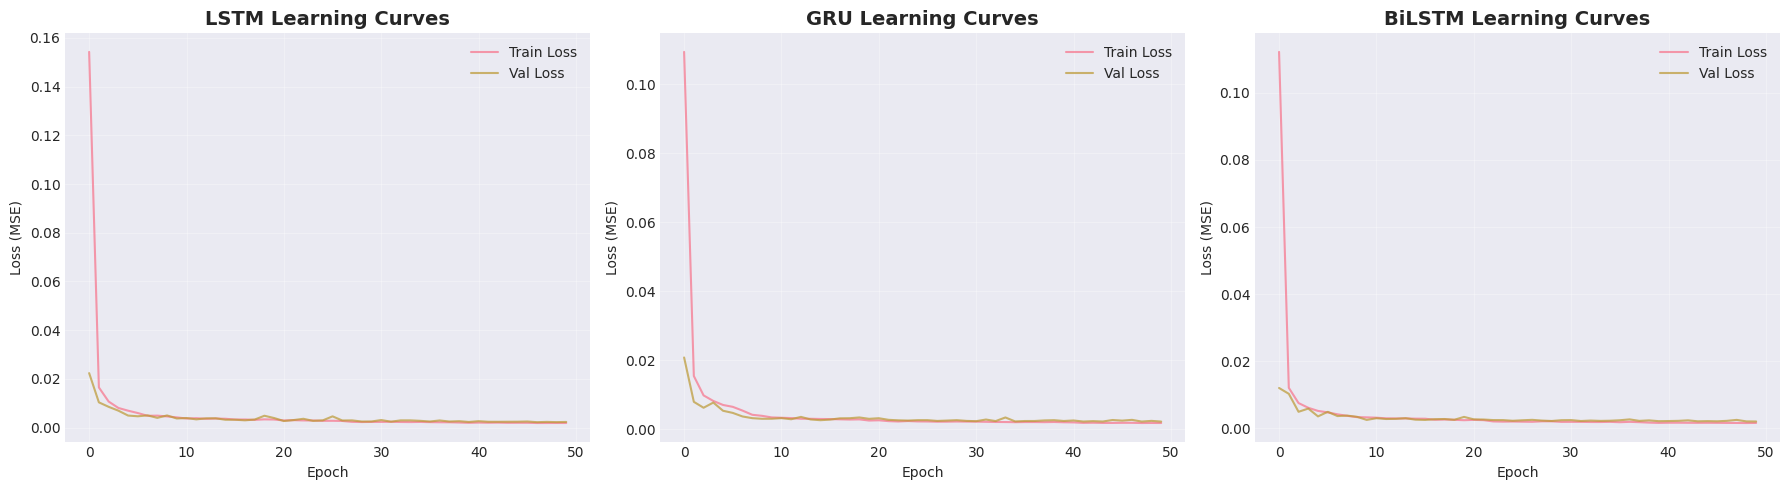

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# LSTM
axes[0].plot(lstm_train_loss, label='Train Loss', alpha=0.7)
axes[0].plot(lstm_val_loss, label='Val Loss', alpha=0.7)
axes[0].set_title('LSTM Learning Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# GRU
axes[1].plot(gru_train_loss, label='Train Loss', alpha=0.7)
axes[1].plot(gru_val_loss, label='Val Loss', alpha=0.7)
axes[1].set_title('GRU Learning Curves', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# BiLSTM
axes[2].plot(bilstm_train_loss, label='Train Loss', alpha=0.7)
axes[2].plot(bilstm_val_loss, label='Val Loss', alpha=0.7)
axes[2].set_title('BiLSTM Learning Curves', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss (MSE)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Visualisierung

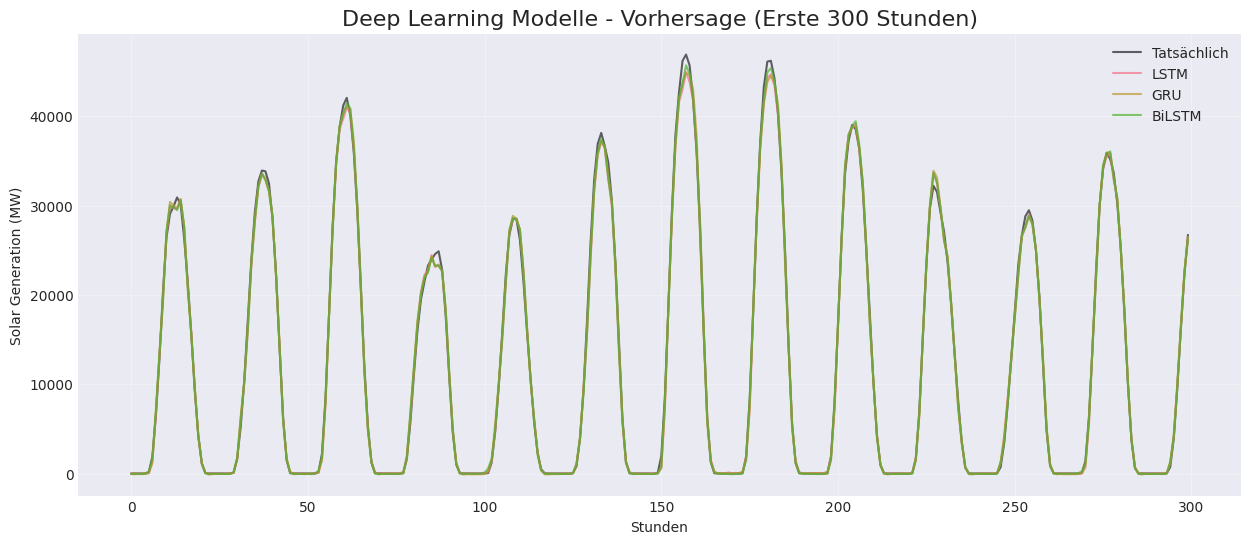

In [12]:
# Zeige nur die ersten 300 Stunden für bessere Sichtbarkeit
plot_len = 300

plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:plot_len], label='Tatsächlich', color='black', alpha=0.6)
plt.plot(lstm_pred[:plot_len], label='LSTM', alpha=0.7)
plt.plot(gru_pred[:plot_len], label='GRU', alpha=0.7)
plt.plot(bilstm_pred[:plot_len], label='BiLSTM', alpha=0.7)

plt.title('Deep Learning Modelle - Vorhersage (Erste 300 Stunden)', fontsize=16)
plt.xlabel('Stunden')
plt.ylabel('Solar Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()